<a href="https://colab.research.google.com/github/ash8m/cost-analysis/blob/main/PneumoniaMNIST_BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_file, to_categorical

In [2]:
# set seed for predictable outputs
#tf.random.set_seed(123)

In [3]:
DATA_NAME = "PneumoniaMNIST"
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]


--2024-04-06 17:48:36--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27766 (27K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  27.12K  --.-KB/s    in 0.002s  

2024-04-06 17:48:36 (17.3 MB/s) - ‘info.py’ saved [27766/27766]



In [4]:
from google.colab import drive
drive.mount('/content/drive')

dataset = np.load('/content/drive/MyDrive/'+DATA_NAME.lower()+'.npz')


Mounted at /content/drive


In [5]:
# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_x = np.expand_dims(train_x, axis=-1)  # Add an extra dimension for the color channel
train_x = tf.image.resize(train_x, (32, 32))  # Resize the images to 32x32
train_x = tf.repeat(train_x, 3, axis=-1)  # Convert grayscale images to RGB
train_x = train_x / 255.0  # Normalize the images
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_x = np.expand_dims(val_x, axis=-1)
val_x = tf.image.resize(val_x, (32, 32))
val_x = tf.repeat(val_x, 3, axis=-1)
val_x = val_x / 255.0
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_x = np.expand_dims(test_x, axis=-1)
test_x = tf.image.resize(test_x, (32, 32))
test_x = tf.repeat(test_x, 3, axis=-1)
test_x = test_x / 255.0
test_y = dataset["test_labels"]


In [6]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]
print(labels)
# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

['normal', 'pneumonia', 'total']
           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


In [7]:
# Load the pre-trained model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
print(len(base_model.layers))

# Freeze the base model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
logits = layers.Dense(1)(x)
# outputs = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, logits)

#model.compile(optimizer=tf.keras.optimizers.Adam(),
#              loss=tf.keras.losses.BinaryCrossentropy(),
#              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()


16705208/16705208 [==============================] - 0s 0us/step
238
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                          

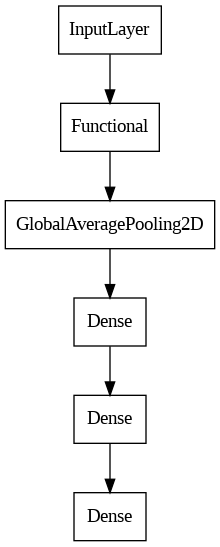

In [8]:
# Visualize the model architecture using plot_model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_layer_names=False, show_shapes=False, show_layer_activations=False)  # Save as PNG and show layer shapes


In [9]:
# Train the model
history = model.fit(train_x, train_y, epochs=5, validation_data=(val_x, val_y))


Epoch 1/5
148/148 [==============================] - 27s 116ms/step - loss: 0.5818 - binary_accuracy: 0.7234 - val_loss: 0.5717 - val_binary_accuracy: 0.7424
Epoch 2/5
148/148 [==============================] - 15s 102ms/step - loss: 0.5766 - binary_accuracy: 0.7421 - val_loss: 0.5713 - val_binary_accuracy: 0.7424
Epoch 3/5
148/148 [==============================] - 15s 104ms/step - loss: 0.5729 - binary_accuracy: 0.7421 - val_loss: 0.5706 - val_binary_accuracy: 0.7424
Epoch 4/5
148/148 [==============================] - 15s 99ms/step - loss: 0.5728 - binary_accuracy: 0.7421 - val_loss: 0.5768 - val_binary_accuracy: 0.7424
Epoch 5/5
148/148 [==============================] - 16s 105ms/step - loss: 0.5725 - binary_accuracy: 0.7421 - val_loss: 0.5711 - val_binary_accuracy: 0.7424


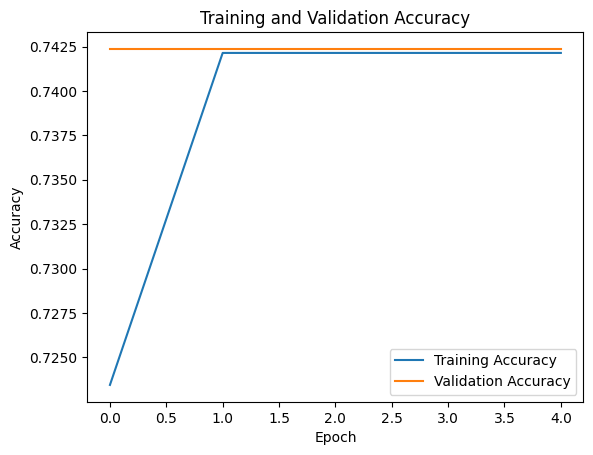

In [10]:
# Access training and validation accuracy/loss from history
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
# Unfreeze the whole base model for fine-tuning
base_model.trainable = True
# unfreeze the last 15 layers
#num_layers = len(base_model.layers)
#for layer in base_model.layers[:num_layers - 15]:
#    layer.trainable = False
#for layer in base_model.layers[num_layers - 15:]:
#    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Fine-tune the model
fine_tune_epochs = 15
total_epochs = 5+15


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1)                 513   

In [12]:
history_fine = model.fit(train_x, train_y,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(val_x, val_y))

Epoch 5/20
148/148 [==============================] - 84s 373ms/step - loss: 0.5714 - binary_accuracy: 0.7421 - val_loss: 0.5692 - val_binary_accuracy: 0.7424
Epoch 6/20
148/148 [==============================] - 51s 347ms/step - loss: 0.5708 - binary_accuracy: 0.7421 - val_loss: 0.5674 - val_binary_accuracy: 0.7424
Epoch 7/20
148/148 [==============================] - 53s 358ms/step - loss: 0.5597 - binary_accuracy: 0.7421 - val_loss: 0.6003 - val_binary_accuracy: 0.7424
Epoch 8/20
148/148 [==============================] - 51s 347ms/step - loss: 0.4047 - binary_accuracy: 0.8073 - val_loss: 0.3138 - val_binary_accuracy: 0.8683
Epoch 9/20
148/148 [==============================] - 52s 350ms/step - loss: 0.3347 - binary_accuracy: 0.8405 - val_loss: 0.3328 - val_binary_accuracy: 0.8149
Epoch 10/20
148/148 [==============================] - 50s 338ms/step - loss: 0.3380 - binary_accuracy: 0.8456 - val_loss: 0.3129 - val_binary_accuracy: 0.8817
Epoch 11/20
148/148 [========================

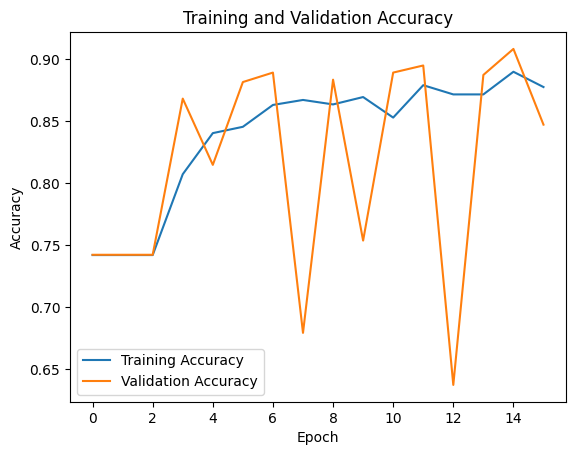

In [13]:
# Access training and validation accuracy/loss from history
train_acc = history_fine.history['binary_accuracy']
val_acc = history_fine.history['val_binary_accuracy']
train_loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

# Plot accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
model.evaluate(test_x, test_y)

20/20 [==============================] - 1s 62ms/step - loss: 0.3140 - binary_accuracy: 0.8494


[0.31397131085395813, 0.8493589758872986]

In [15]:
model.save_weights("/content/drive/MyDrive/fine_tuned_weights_new.h5", save_format="h5")
model.save("/content/drive/MyDrive/fine_tuned_model_new.keras")

In [16]:
# model = tf.keras.models.load_model("/content/drive/MyDrive/fine_tuned_model.keras")
model.load_weights("/content/drive/MyDrive/fine_tuned_weights.h5")

In [17]:
from tensorflow.keras import Model
from keras.initializers import Constant
initializer = Constant(1)

class UnCalibratedModel(Model):
  def __init__(self, base_model):
    super(UnCalibratedModel, self).__init__()
    self.base_model = base_model

    self.sigmoid_layer = layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)

  def call(self, inputs):
    x = self.base_model(inputs)
    return self.sigmoid_layer(x)

# Load and freeze the pre-trained model

# Create the calibration model
prob_model = UnCalibratedModel(model)


In [18]:
logit_test = model.predict(test_x)
#print(logit_test[:10])
predictions_none = tf.sigmoid(logit_test)

df = pd.DataFrame({
    'label': test_y.flatten(),
    'prediction': predictions_none.numpy().flatten()  # Flatten to make it 1D
})

path = "/content/drive/MyDrive/medmnist_predictions_none.csv"

df.to_csv(path, index=False)


20/20 [==============================] - 4s 59ms/step


Prep a dataset with the logits and corresponding labels to be used to learn the temperature parameter

In [19]:
validation_logits = model.predict(val_x)
validation_logits.shape

17/17 [==============================] - 1s 63ms/step


(524, 1)

In [20]:
val_y = tf.cast(val_y, tf.float32)
val_y[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

In [21]:
N_EPOCHS = 20
data = tf.data.Dataset.from_tensor_slices((validation_logits, val_y)).repeat(N_EPOCHS)

create a custom model which can be used for training to learn the temperature parameter

In [22]:
class CalibrationModel(Model):
    def __init__(self):
        super().__init__()
        self.temperature = tf.Variable(1.0)

    def call(self, logits: tf.Tensor):
        return logits / self.temperature

In [23]:
calib_model = CalibrationModel()

In [24]:
def loss(labels: tf.Tensor, logits: tf.Tensor):
    """Loss function"""
    return tf.nn.sigmoid_cross_entropy_with_logits(labels, logits)


optimiser = tf.optimizers.Adam(learning_rate=0.001)

In [25]:
from tqdm import tqdm
history = []

for epoch in tqdm(range(N_EPOCHS)):
    for step, (batch_x, batch_y) in enumerate(data.batch(32)):
        try:
            with tf.GradientTape() as tape:
                logits = calib_model(batch_x)
                batch_loss = loss(batch_y, logits)
            gradients = tape.gradient(batch_loss, [calib_model.temperature])
            optimiser.apply_gradients(zip(gradients, calib_model.trainable_variables))

            history.append(
                {
                    "loss": batch_loss.numpy().mean(),
                    "epoch": epoch,
                    "step": step,
                    "temperature": calib_model.temperature.numpy(),
                }
            )
        except tf.errors.InvalidArgumentError:
            history.append(
                {
                    "loss": 100,
                    "epoch": 100,
                    "step": 100,
                    "temperature": 100,
                }
            )
            break

100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


<Axes: xlabel='epoch'>

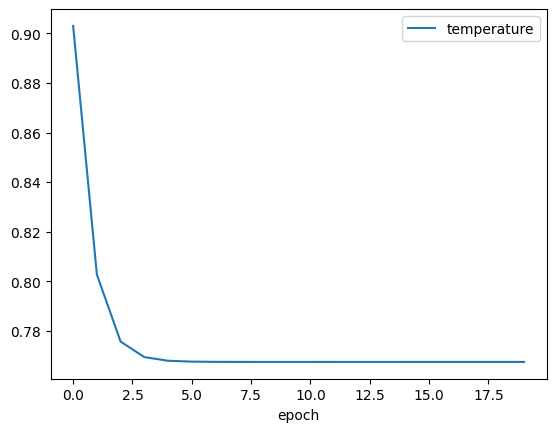

In [26]:
history_df = pd.DataFrame(history)
history_df.groupby("epoch").mean().plot(y="temperature")

<Axes: xlabel='epoch'>

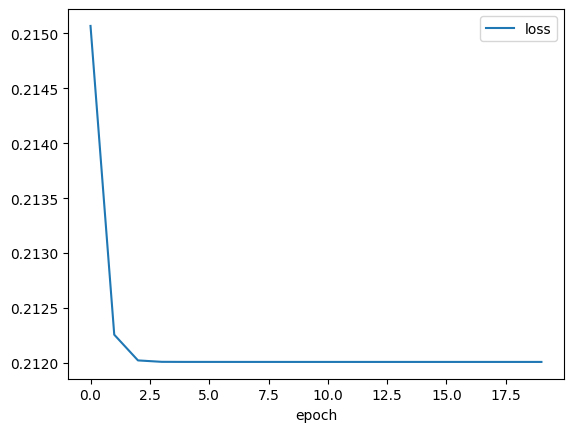

In [27]:
history_df.groupby("epoch").mean().plot(y="loss")

In [28]:
calib_model.temperature.numpy()

0.76739895

In [29]:
logit_test = model.predict(test_x)
#print(logit_test[:10])
temp_scaled = logit_test/calib_model.temperature.numpy()

predictions_temp = tf.sigmoid(temp_scaled)

df = pd.DataFrame({
    'label': test_y.flatten(),
    'prediction': predictions_temp.numpy().flatten()  # Flatten to make it 1D
})

path = "/content/drive/MyDrive/medmnist_predictions_temp.csv"

df.to_csv(path, index=False)


20/20 [==============================] - 1s 60ms/step


In [30]:
validation_logits_mod = validation_logits[validation_logits<0].reshape(-1,1)
print(validation_logits_mod.shape)
val_y_mod = val_y.numpy()
val_y_mod = val_y_mod[validation_logits<0].reshape(-1,1)

(130, 1)


In [31]:
N_EPOCHS = 20
data = tf.data.Dataset.from_tensor_slices((validation_logits_mod, val_y_mod)).repeat(N_EPOCHS)

In [32]:
calib_model_mod = CalibrationModel()

In [33]:
from tqdm import tqdm
history = []
optimiser = tf.optimizers.Adam(learning_rate=0.001)
for epoch in tqdm(range(N_EPOCHS)):
    for step, (batch_x, batch_y) in enumerate(data.batch(32)):
        try:
            with tf.GradientTape() as tape:
                logits = calib_model_mod(batch_x)
                batch_loss = loss(batch_y, logits)
            gradients = tape.gradient(batch_loss, [calib_model_mod.temperature])
            optimiser.apply_gradients(zip(gradients, calib_model_mod.trainable_variables))

            history.append(
                {
                    "loss": batch_loss.numpy().mean(),
                    "epoch": epoch,
                    "step": step,
                    "temperature": calib_model_mod.temperature.numpy(),
                }
            )
        except tf.errors.InvalidArgumentError:
            history.append(
                {
                    "loss": 100,
                    "epoch": 100,
                    "step": 100,
                    "temperature": 100,
                }
            )
            break

100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


<Axes: xlabel='epoch'>

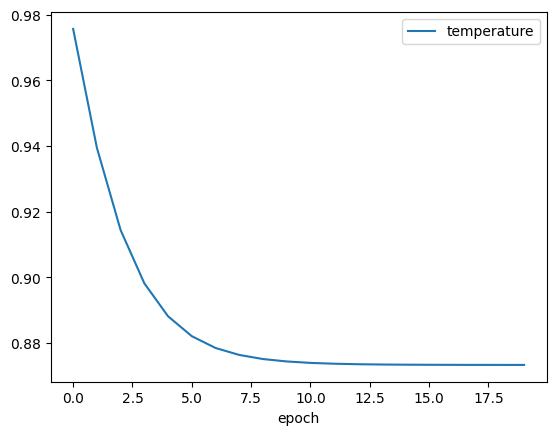

In [34]:
history_df = pd.DataFrame(history)
history_df.groupby("epoch").mean().plot(y="temperature")

<Axes: xlabel='epoch'>

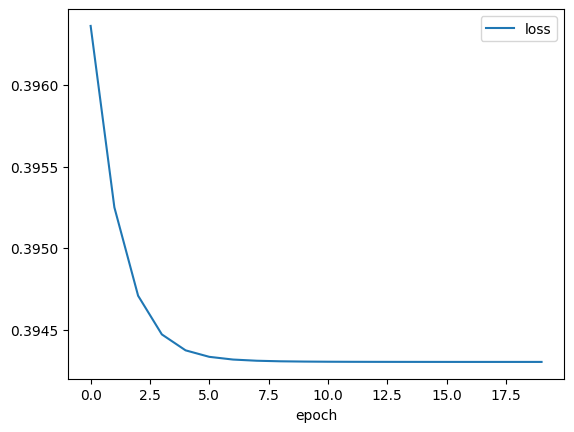

In [35]:
history_df.groupby("epoch").mean().plot(y="loss")

In [36]:
calib_model_mod.temperature.numpy()

0.87346464

In [37]:
logit_test = model.predict(test_x)
#print(logit_test[:10])
temp_scaled = logit_test/calib_model_mod.temperature.numpy()

predictions_mod_temp = tf.sigmoid(temp_scaled)

df = pd.DataFrame({
    'label': test_y.flatten(),
    'prediction': predictions_temp.numpy().flatten()  # Flatten to make it 1D
})

path = "/content/drive/MyDrive/medmnist_predictions_temp.csv"

df.to_csv(path, index=False)


20/20 [==============================] - 1s 62ms/step


Verifying with the code available here \
https://github.com/nplan-io/kdd2020-calibration/blob/master/tutorial/KDD%202020%20-%20nPlan%20calibration%20session%20(completed).ipynb

In [38]:
from scipy.special import expit
from sklearn.metrics import log_loss

def scale_fun_ce(x, *args):
    """Returns the NLL of the model over the validation set when scaled
    by the t parameter
    """
    t = x[0]
    y_logit_scaled = validation_logits_mod/t
    y_pred_inner = expit(y_logit_scaled)
    return log_loss(val_y_mod, y_pred_inner)

In [39]:
from scipy.optimize import minimize

min_obj = minimize(scale_fun_ce,[1],method='Nelder-Mead',options={'xatol': 1e-13, 'disp': True})
min_obj.x[0]

Optimization terminated successfully.
         Current function value: 0.396650
         Iterations: 42
         Function evaluations: 107


0.8733856678009032

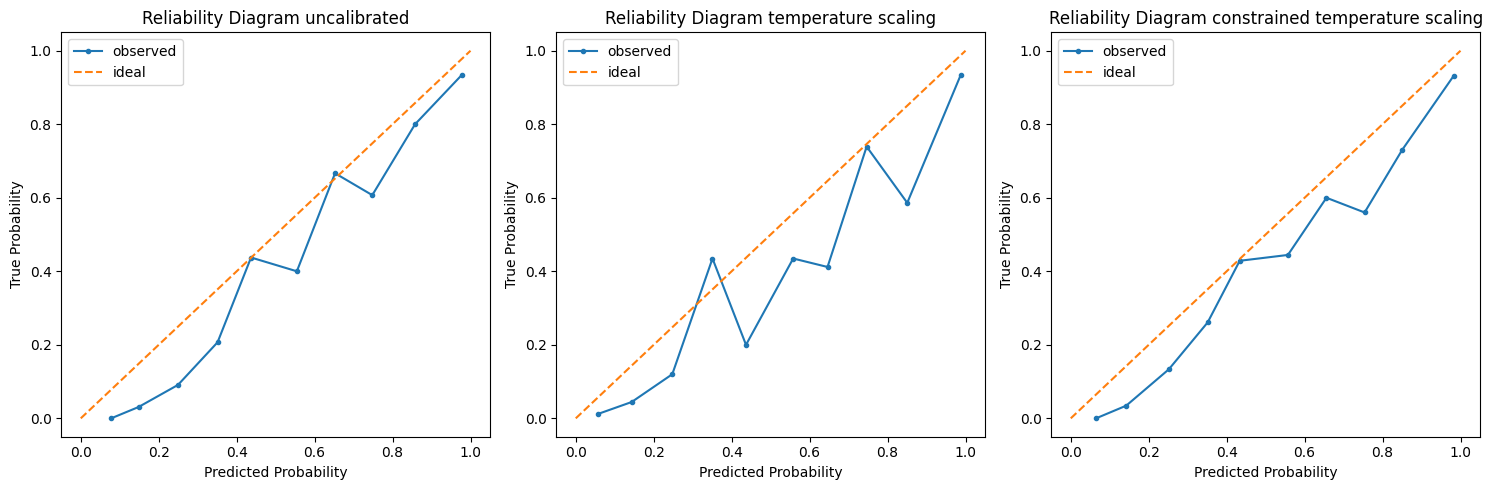

In [41]:
from sklearn.calibration import calibration_curve
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

prob_true_2, prob_pred_2 = calibration_curve(test_y.flatten(), predictions_none.numpy().flatten(), n_bins=10)
axes[0].plot(prob_pred_2, prob_true_2, marker='.', label="observed")
axes[0].plot([0, 1], [0, 1], linestyle='--', label="ideal")
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('True Probability')
axes[0].set_title('Reliability Diagram uncalibrated')
axes[0].legend()

prob_true_3, prob_pred_3 = calibration_curve(test_y.flatten(), predictions_temp.numpy().flatten(), n_bins=10)
axes[1].plot(prob_pred_3, prob_true_3, marker='.', label="observed")
axes[1].plot([0, 1], [0, 1], linestyle='--', label="ideal")
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('True Probability')
axes[1].set_title('Reliability Diagram temperature scaling')
axes[1].legend()

# plot post-calibration reliability diag
prob_true_4, prob_pred_4 = calibration_curve(test_y.flatten(), predictions_mod_temp.numpy().flatten(), n_bins=10)
axes[2].plot(prob_pred_4, prob_true_4, marker='.', label="observed")
axes[2].plot([0, 1], [0, 1], linestyle='--', label="ideal")
axes[2].set_xlabel('Predicted Probability')
axes[2].set_ylabel('True Probability')
axes[2].set_title('Reliability Diagram constrained temperature scaling')
axes[2].legend()
plt.tight_layout()
plt.show()